In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [3]:
from keras import regularizers

In [4]:
import os
import pandas as pd

In [5]:
mylist= os.listdir('Data/')

In [6]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_positive')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_positive')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_positive')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_positive')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_negative')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_negative')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_negative')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_negative')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_negative')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_negative')
    elif item[:1]=='a':
        feeling_list.append('male_negative')
    elif item[:1]=='f':
        feeling_list.append('male_negative')
    elif item[:1]=='h':
        feeling_list.append('male_positive')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_negative')

# Новый раздел

In [7]:
labels = pd.DataFrame(feeling_list)
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [8]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [9]:
newdf = pd.concat([df3,labels], axis=1)

In [10]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [11]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)

In [12]:
rnewdf=rnewdf.fillna(0)

In [13]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [14]:
trainfeatures = train.iloc[:, :-1]

In [15]:
trainlabel = train.iloc[:, -1:]

In [16]:
testfeatures = test.iloc[:, :-1]

In [17]:
testlabel = test.iloc[:, -1:]

In [18]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [21]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_5 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_6 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 27, 128)          

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [24]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
95/95 [==============================] - 10s 105ms/step - loss: 1.3602 - accuracy: 0.3627 - val_loss: 1.2787 - val_accuracy: 0.4305
Epoch 2/700
95/95 [==============================] - 9s 99ms/step - loss: 1.2169 - accuracy: 0.4924 - val_loss: 1.1887 - val_accuracy: 0.5313
Epoch 3/700
95/95 [==============================] - 10s 103ms/step - loss: 1.1397 - accuracy: 0.5169 - val_loss: 1.1252 - val_accuracy: 0.5504
Epoch 4/700
95/95 [==============================] - 10s 101ms/step - loss: 1.0867 - accuracy: 0.5288 - val_loss: 1.0831 - val_accuracy: 0.5477
Epoch 5/700
95/95 [==============================] - 10s 102ms/step - loss: 1.0405 - accuracy: 0.5533 - val_loss: 1.0337 - val_accuracy: 0.5586
Epoch 6/700
95/95 [==============================] - 10s 100ms/step - loss: 1.0056 - accuracy: 0.5381 - val_loss: 1.0044 - val_accuracy: 0.5259
Epoch 7/700
95/95 [==============================] - 10s 102ms/step - loss: 0.9807 - accuracy: 0.5433 - val_loss: 0.9753 - val_accuracy: 0

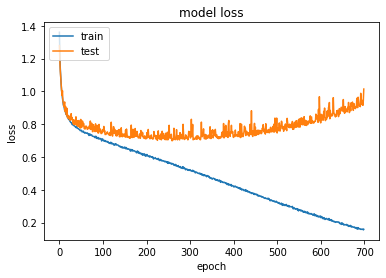

In [25]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined